In [109]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk 
import string
import re
import codecs
import json
#%matplotlib inline
#pd.set_option('display.max_colwidth', 100)

import hdbscan
import nltk
import numpy as np
import pandas as pd
import random
import re
import spacy
import textacy
import csv
import sklearn

from gmplot import gmplot
from mapsplotlib import mapsplot as mplt
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag_sents
from pymprog import *
from sklearn.cluster import DBSCAN
from sklearn.neighbors import DistanceMetric
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd

import datetime
from time import strptime

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings('ignore')

time: 4.99 ms


In [2]:
# fname = "relevant_json.json"
# list_tweets = []
# count = 0 
# sum = 1000
# with open(fname,encoding="utf8") as f:
#     for line in f:
#         try:
#             tweet = json.loads(line)
#         except:
#             pass
#         list_tweets.append(tweet)

# df_relevant = pd.DataFrame(data=[tweet["full_text"] for tweet in list_tweets], columns=['tweets'])
# df_relevant['created_at'] = np.array([tweet["created_at"] for tweet in list_tweets])
# df_relevant['id'] = np.array([int(tweet["id_str"]) for tweet in list_tweets])
# df_relevant['rt'] = np.array([tweet["retweeted"] for tweet in list_tweets])
# df_relevant['lang'] = np.array([tweet["lang"] for tweet in list_tweets])
# df_relevant['Predicted_Event'] = -1

# fname = "relevant_tweets.tsv"
# event_id = pd.read_csv(fname, sep='\t',header=None,names=['Event','id'])

# df_relevant = df_relevant.merge(event_id, left_on='id', right_on='id')
# df_relevant.head(1)

In [3]:
colnames=['tweets', 'created_at', 'id','rt','lang','location','coordinates','Event'] 
df_relevant = pd.read_csv('relevant_with_coordinates.csv', names=colnames, header=None)
print(df_relevant.shape[0])
df_relevant.head(1)

106017


,tweets,created_at,id,rt,lang,location,coordinates,Event
0,News: Chinese author Mo Yan wins Nobel http://...,Thu Oct 11 11:08:32 +0000 2012,256350567369175040,False,en,Eindhoven,"{""lat"": 51.47601928708412, ""lon"": 5.4647688255...",0


In [4]:
# json.loads(df_relevant["coordinates"][0])['lat']

In [5]:
colnames=['tweets', 'created_at', 'id','rt','lang','location','coordinates'] 
df_irrelevant = pd.read_csv('irrelevant_with_coordinates.csv', names=colnames, header=None)
df_irrelevant['Event'] = -1
print(df_irrelevant.shape[0])
df_irrelevant.head(1)

413986


,tweets,created_at,id,rt,lang,location,coordinates,Event
0,I love ms.sivney class (Sports &amp; Entertaim...,Wed Oct 31 16:48:39 +0000 2012,263683917889040400,False,en,Macedonia,"{'lat': 41.82038761113906, 'lon': 22.008566323...",-1


In [6]:
frames = [df_relevant,df_irrelevant]
df = pd.concat(frames)

## Remove tweets that are not in English

Index(['en', 'und', 'in', 'tl', 'es', 'ht', 'fr', 'et', 'pt', 'de', 'nl', 'ca',
       'ro', 'da', 'it', 'pl', 'cy', 'cs', 'sv', 'ja', 'no', 'tr', 'fi', 'hi',
       'lt', 'zh', 'hu', 'lv', 'ko', 'eu', 'sl', 'vi', 'is', 'ar', 'th', 'ru',
       'hy', 'my'],
      dtype='object')


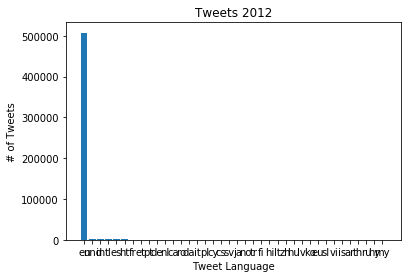

In [7]:
import matplotlib.pyplot as plt
# plots number of tweets in each language
counts = df['lang'].value_counts()
plt.bar(counts.index, counts, align='center', alpha=1)
plt.xlabel('Tweet Language')
plt.ylabel('# of Tweets')
plt.title('Tweets 2012')
print(counts.index)

In [8]:
print("Old df shape:",df.shape[0])
df = df.loc[df["lang"]=='en']
print("New df shape:",df.shape[0])

Old df shape: 520003
New df shape: 507519


In [9]:
df = df.reset_index(drop=True)

def create_date(text):
    temp = text.split(" ")
    x = str(datetime.datetime(int(temp[5]),int(strptime(temp[1],'%b').tm_mon),int(temp[2]))).split()[0]
    return x

df['date'] = df['created_at'].apply(lambda x: create_date(x))
df['time'] =  np.array([tweet.split()[3] for tweet in df["created_at"]])
df['Datetime']= pd.to_datetime(df['date'].apply(str)+' '+df['time'].apply(lambda x: x.split(':')[0]) + df['time'].apply(lambda x: x.split(':')[1]))
df['DateHour'] = pd.to_datetime(df['date'].apply(str)+' '+df['time'].apply(lambda x: x.split(':')[0])+':00')
df['Date_Ten_Minutes'] = pd.to_datetime(df['date'].apply(str)+' '+df['time'].apply(lambda x: x.split(':')[0])+':'+df["time"].apply(lambda x: x.split(":")[1][0]+'0'))

tableFlag=[]
data_sorted = df.sort_values(by=['date'],inplace=False)
data_sorted = data_sorted.reset_index(drop=True)

list_date_ten = []
for temp in data_sorted["Date_Ten_Minutes"]:
    list_date_ten.append(temp)

list_date_ten = list(dict.fromkeys(list_date_ten))
list_date_ten = sorted(list_date_ten)
print(len(list_date_ten))

4033


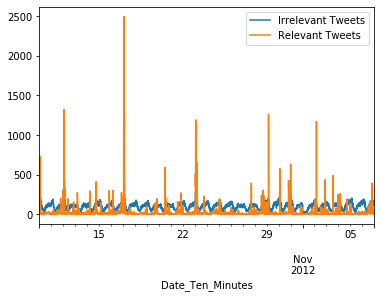

In [10]:
df_relevant['date'] = df_relevant['created_at'].apply(lambda x: create_date(x))
df_relevant['time'] =  np.array([tweet.split()[3] for tweet in df_relevant["created_at"]])
df_relevant['DateHour'] = pd.to_datetime(df_relevant['date'].apply(str)+' '+df_relevant['time'].apply(lambda x: x.split(':')[0])+':00')
df_relevant['Date_Ten_Minutes'] = pd.to_datetime(df_relevant['date'].apply(str)+' '+df_relevant['time'].apply(lambda x: x.split(':')[0])+':'+df_relevant["time"].apply(lambda x: x.split(":")[1][0]+'0'))
df_relevant['Datetime']= pd.to_datetime(df_relevant['date'].apply(str)+' '+df_relevant['time'].apply(lambda x: x.split(':')[0]) + df_relevant['time'].apply(lambda x: x.split(':')[1]))


df_irrelevant['date'] = df_irrelevant['created_at'].apply(lambda x: create_date(x))
df_irrelevant['time'] =  np.array([tweet.split()[3] for tweet in df_irrelevant["created_at"]])
df_irrelevant['DateHour'] = pd.to_datetime(df_irrelevant['date'].apply(str)+' '+df_irrelevant['time'].apply(lambda x: x.split(':')[0])+':00')
df_irrelevant['Date_Ten_Minutes'] = pd.to_datetime(df_irrelevant['date'].apply(str)+' '+df_irrelevant['time'].apply(lambda x: x.split(':')[0])+':'+df_irrelevant["time"].apply(lambda x: x.split(":")[1][0]+'0'))
df_irrelevant['Datetime']= pd.to_datetime(df_irrelevant['date'].apply(str)+' '+df_irrelevant['time'].apply(lambda x: x.split(':')[0]) + df_irrelevant['time'].apply(lambda x: x.split(':')[1]))


# graphing the threshold vs hourly tweet occurences
dfchange = df_irrelevant.loc[df_irrelevant['date'] != -1]
ts = dfchange.set_index('Date_Ten_Minutes')
vc = ts.groupby('Date_Ten_Minutes').count()
col = ['id']
vc2 = vc[col]
vc3 = vc2.copy()


dfchange1 = df_relevant.loc[df_relevant["date"]!=-1]
rs = dfchange1.set_index('Date_Ten_Minutes')
rc = rs.groupby('Date_Ten_Minutes').count()
col = ['id']
rc2 = rc[col]
rc3 = rc2.copy()

vc3.rename(columns={'id':'Irrelevant Tweets'},inplace=True)

rc3.rename(columns={'id':'Relevant Tweets'},inplace=True)

ax = vc3.plot()
rc3.plot(ax = ax)

In [11]:
tableFlag=[]
data_sorted = df.sort_values(by=['date'],inplace=False)
data_sorted = data_sorted.reset_index(drop=True)

list_date_minutes = []
for temp in data_sorted["Datetime"]:
    list_date_minutes.append(temp)

list_date_minutes = list(dict.fromkeys(list_date_minutes))
list_date_minutes = sorted(list_date_minutes)
print(len(list_date_minutes))

39951


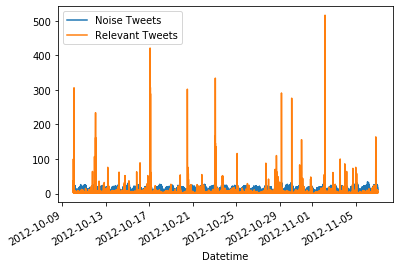

In [12]:
# gca stands for 'get current axis'
# graphing the threshold vs hourly tweet occurences
dfchange = df_irrelevant.loc[df_irrelevant['date'] != -1]
ts = dfchange.set_index('Datetime')
vc = ts.groupby('Datetime').count()
col = ['id']
vc2 = vc[col]
vc3 = vc2.copy()


dfchange1 = df_relevant.loc[df_relevant["date"]!=-1]
rs = dfchange1.set_index('Datetime')
rc = rs.groupby('Datetime').count()
col1 = ['id']
rc2 = rc[col1]
rc3 = rc2.copy()

vc3.rename(columns={'id':'Noise Tweets'},inplace=True)
rc3.rename(columns={'id':'Relevant Tweets'},inplace=True)

ax = vc3.plot()
rc3.plot(ax = ax)

In [13]:
list_date_hour = []
for temp in data_sorted["DateHour"]:
    list_date_hour.append(temp)

list_date_hour = list(dict.fromkeys(list_date_hour))
list_date_hour = sorted(list_date_hour)
print(len(list_date_hour))

673


# Flagging all potential eventful tweets

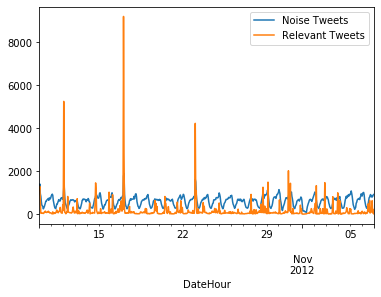

In [14]:
# gca stands for 'get current axis'
# graphing the threshold vs hourly tweet occurences
dfchange = df_irrelevant.loc[df_irrelevant['date'] != -1]
ts = dfchange.set_index('DateHour')
vc = ts.groupby('DateHour').count()
col = ['id']
vc2 = vc[col]
vc3 = vc2.copy()


dfchange1 = df_relevant.loc[df_relevant["date"]!=-1]
rs = dfchange1.set_index('DateHour')
rc = rs.groupby('DateHour').count()
col1 = ['id']
rc2 = rc[col1]
rc3 = rc2.copy()

vc3.rename(columns={'id':'Noise Tweets'},inplace=True)
rc3.rename(columns={'id':'Relevant Tweets'},inplace=True)

ax = vc3.plot()
rc3.plot(ax = ax)

In [15]:
df_relevant.shape[0]

106017

In [16]:
df_irrelevant.shape[0]

413986

<h3> Remove hashtags,mentions,retweets from the tweet and import them to a new column </h3>

In [17]:
def remove_patterns(input_txt,mentions,hashtags,RT):
    m = re.findall(mentions, input_txt)
    h = re.findall(hashtags,input_txt)
    r = re.findall(RT,input_txt)
    u = re.findall(r"http\S+",input_txt)
    mention_list = []
    hashtag_list = []
    url_list = []
    rt1 = 0
    
    
    for i in u:
        url_list.append(i)
        #input_txt = re.sub(i,'',input_txt)
    input_txt = re.sub(r"http\S+",'',input_txt)
    for i in m:
        mention_list.append(i)
        input_txt = re.sub(i, '', input_txt)
    for i in h:
        hashtag_list.append(i)
        input_txt = re.sub(i,'',input_txt)
    if r!=0 :
        rt1 = 1
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    #Some json
    x = {"input_text" : input_txt,"user_mentions":mention_list,"hashtags":hashtag_list,"is_RT":rt1,"is_URL":url_list}
    #y = json.dumps(x)
    return x

def list_lower(temp):
    list_lower =[]
    for text in temp:
        list_lower.append(text.lower())
    return list_lower

temp = np.vectorize(remove_patterns)(df['tweets'],"@[\w]*","#[\w]*","RT")

#print(df["Orig_Tweet"][12])
df["text"] = np.array([text["input_text"] for text in temp])
#df2["hashtag"] = np.array([text["hashtags"] for text in temp])
df["hashtag"] = np.array([list_lower(text["hashtags"]) for text in temp])
df["user_mentions"] = np.array([text["user_mentions"] for text in temp]) 
df["RT"] = np.array([text["is_RT"] for text in temp])
df["URL"] = np.array([text["is_URL"] for text in temp])

<h3> Remove punctuation and Tokenization</h3>

In [18]:
def remove_punct(text):
    temp = string.punctuation+"…"
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def tokenization(text):
    text = re.split('\W+', text)
    #text = nltk.word_tokenize(text)
    temp=[]
    for i in text:
        if i!='':
            temp.append(i)
    return temp

df['Tweet_punct'] = df['text'].apply(lambda x: remove_punct(x))
df['Tweet_tokenized'] = df['Tweet_punct'].apply(lambda x: tokenization(x.lower()))
# df.head()

<h3>Remove stopwords</h3>

In [19]:
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

df['Tweet_nonstop'] = df['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))

<h3> Stemming </h3

In [20]:
# Stemming is the process of breaking a word down into its root.
stemmer = SnowballStemmer('english')
stops = set(stopwords.words("english"))

def stemming_to_sent(words):
    stemmed_words = [stemmer.stem(w) for w in words]
    return(" ".join(stemmed_words))
def stemming_to_words(words):
    stemmed_words = [stemmer.stem(w) for w in words]
    return stemmed_words

df["Stem_sent"] = np.array([stemming_to_sent(temp) for temp in df["Tweet_nonstop"]])
df["Stem_words"] = np.array([stemming_to_words(temp) for temp in df["Tweet_nonstop"]])
df["No"] = np.array([i for i in range(0,df.shape[0])])

In [21]:
# [print(json.loads(row)['lat']) for row in df["coordinates"]]

# Reverse Geocoding

In [22]:
%load_ext autotime
import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

C:\Users\giann\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`



In [23]:
def new_clean_data(i,df_temp):
#     import pdb; pdb.set_trace()
    sent = ""
    for temp in df_temp["Stem_words"].get(i):
        sent+= temp + " "
    for temp in df_temp["hashtag"].get(i):
        sent+= temp + " "
    for temp in df_temp["user_mentions"].get(i):
        sent+= temp+ " "
    for temp in df_temp["URL"].get(i):
        sent+= temp + " "
    return sent

df["clean_data"] = np.array([new_clean_data(i,df) for i in range(df.shape[0])])

time: 49.2 s


In [24]:
tweetsContentLocation = df.copy()["clean_data"]
tweetsContentLocation.shape[0]

result = [df['coordinates'][tweetsContentLocation.index[i]] for i in range(tweetsContentLocation.shape[0])]
list_location = []
for i in range(len(result)):
    row = result[i].replace("\'", "\"")
    row = json.loads(row)
    lat = row['lat']
    lon = row['lon']
    coordinates = (lat,lon)
    list_location.append(coordinates)

time: 12.5 s


In [25]:
import reverse_geocoder as rg
results = rg.search(list_location)
count = 100000
for i in range(len(results)):
                if (i==count):
                    print(i)
                    count+=100000
                place = tweetsContentLocation.index[i]
                if results[i]['name']:
                    tweetsContentLocation[place] += results[i]['name'] + ' '
                if results[i]['admin1']:
                    tweetsContentLocation[place] += results[i]['admin1'] + ' '
                if results[i]['admin2']:
                    tweetsContentLocation[place] += results[i]['admin2'] + ' '
                if results[i]['cc']:
                    tweetsContentLocation[place] += results[i]['cc'] + ' '
# df["clean_data"] = tweetsContent

Loading formatted geocoded file...
100000
200000
300000
400000
500000
time: 49.7 s


In [26]:
df["clean_data_coordinates"] = tweetsContentLocation

time: 16 ms


# TFIDF Vectorization

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
def getTfIdf(clean_train,windows_corpus,ngram1,ngram2,mindf,maxdf):
    if (mindf==0):
        minimum = 1
    else:
#         minimum = max(int(windows_corpus * 0.0025), 10)
        minimum = 5
    if (maxdf==0):
        maximum = 1.0
    else:
        maximum = 0.8  
        
    tfidf_vectorizer = TfidfVectorizer(
                                       min_df=minimum,
                                       max_df=maximum,
                                       max_features=2000000,
                                       stop_words='english',
                                       use_idf=True,
                                       ngram_range=(ngram1,ngram2)
    )
    # Tf-idf-weighted term-document sparse matrix
    try :
        tfidf_train_data_features = tfidf_vectorizer.fit_transform(clean_train)
    except:
#         print("Hello")
        tfidf_vectorizer = TfidfVectorizer(max_features=2000000,stop_words='english',use_idf=True,ngram_range=(1,3))
        tfidf_train_data_features = tfidf_vectorizer.fit_transform(clean_train)
        minimum = 1
        maximum = 1.0
    finally:
        list_sum = []
        for i in range(0,tfidf_train_data_features.shape[0]):
            list_sum.append(tfidf_train_data_features[i].count_nonzero())
                
        return {'tfidf_train_data_features':tfidf_train_data_features,'minimum':minimum,'maximum':maximum,'sum':list_sum}

time: 5.99 ms


In [28]:
# function to get unique values 
def getNumClusters(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    return len(unique_list)

# take second element for sort
def takeSecond(elem):
    return elem[1]

time: 15 ms


# Affinity Propagation Clustering

In [29]:
from sklearn.cluster import AffinityPropagation
def getAffinity(tweets,tfidf):
    clustering = AffinityPropagation().fit(tfidf.toarray())
    
    clusters = clustering.labels_.tolist()
    temp = clusters.copy()
    temp.remove
    
    addedCluster = tweets.copy()
    addedCluster['Cluster'] = clusters
    num_clusters = getNumClusters(clusters)

    pd.options.display.max_colwidth = 100

    cls = []
    #num_clusters = 55
    max_num_cluster = 0

    for i in range(0, num_clusters):
        tweetsInCluster = addedCluster[addedCluster['Cluster'] == i]
        if(tweetsInCluster.shape[0] > 0):
            cls.append((tweetsInCluster,tweetsInCluster.shape[0]))
            
#     cls.sort(key=takeSecond,reverse=True)
    clusters = []
    for i in range(len(cls)):
        clusters.append(cls[i][0])
    
    return {"clusters":clusters,"labels_pr":clustering.labels_.tolist()}
    

time: 18 ms


# KMeans Clustering

In [30]:
from sklearn.cluster import KMeans
def getKMeans(tweets,tfidf):
    clustering = KMeans(n_clusters=5,n_jobs=-1).fit(tfidf.toarray())
    
    clusters = clustering.labels_.tolist()
    temp = clusters.copy()
    temp.remove
    
    addedCluster = tweets.copy()
    addedCluster['Cluster'] = clusters
    num_clusters = getNumClusters(clusters)

    pd.options.display.max_colwidth = 100

    cls = []
    #num_clusters = 55
    max_num_cluster = 0

    for i in range(0, num_clusters):
        tweetsInCluster = addedCluster[addedCluster['Cluster'] == i]
        if(tweetsInCluster.shape[0] > 0):
            cls.append((tweetsInCluster,tweetsInCluster.shape[0]))
            
#     cls.sort(key=takeSecond,reverse=True)
    clusters = []
    for i in range(len(cls)):
        clusters.append(cls[i][0])
    
    return {"clusters":clusters,"labels_pr":clustering.labels_.tolist()}
    

time: 17 ms


# Hierarchical Clustering

In [31]:
from sklearn.cluster import AgglomerativeClustering
def getHierarchical(tweets,tfidf):
    clustering = AgglomerativeClustering(n_clusters=5).fit(tfidf.toarray())
    
    clusters = clustering.labels_.tolist()
    temp = clusters.copy()
    temp.remove
    
    addedCluster = tweets.copy()
    addedCluster['Cluster'] = clusters
    num_clusters = getNumClusters(clusters)

    pd.options.display.max_colwidth = 100

    cls = []
    #num_clusters = 55
    max_num_cluster = 0

    for i in range(0, num_clusters):
        tweetsInCluster = addedCluster[addedCluster['Cluster'] == i]
        if(tweetsInCluster.shape[0] > 0):
            cls.append((tweetsInCluster,tweetsInCluster.shape[0]))
            
#     cls.sort(key=takeSecond,reverse=True)
    clusters = []
    for i in range(len(cls)):
        clusters.append(cls[i][0])
    
    return {"clusters":clusters,"labels_pr":clustering.labels_.tolist()}
    

time: 3.99 ms


# HDBSCAN (Hierarchical Density-based Clustering)

In [32]:
def getHDBSCAN(tweets,tfidf):
    clustering = hdbscan.HDBSCAN(min_cluster_size=5,metric='cosine').fit(tfidf)
    
    clusters = clustering.labels_.tolist()
    temp = clusters.copy()
    temp.remove
    
    addedCluster = tweets.copy()
    addedCluster['Cluster'] = clusters
    num_clusters = getNumClusters(clusters)

    pd.options.display.max_colwidth = 100

    cls = []
    #num_clusters = 55
    max_num_cluster = 0

    for i in range(0, num_clusters):
        tweetsInCluster = addedCluster[addedCluster['Cluster'] == i]
        if(tweetsInCluster.shape[0] > 0):
            cls.append((tweetsInCluster,tweetsInCluster.shape[0]))
            
#     cls.sort(key=takeSecond,reverse=True)
    clusters = []
    for i in range(len(cls)):
        clusters.append(cls[i][0])
        
    #Noise Data
    noise_data = addedCluster[addedCluster['Cluster']==-1]
#     noise_data = addedCluster[addedCluster['Cluster'] == -1]
#     print("Size:",noise_data.shape[0])
#     print(noise_data["tweets"],noise_data["Event"])
    
    return {"clusters":clusters,"noise_data":noise_data,"labels_pr":clustering.labels_.tolist()}

time: 5.98 ms


# DBSCAN Clustering (Density-based Clustering)

In [33]:
def getDBSCAN(tweets,tfidf,e):
    clustering = DBSCAN(eps=e, min_samples=5,n_jobs=-1,metric='cosine').fit(tfidf)
    
    clusters = clustering.labels_.tolist()
    temp = clusters.copy()
    temp.remove
    
    addedCluster = tweets.copy()
    addedCluster['Cluster'] = clusters
    num_clusters = getNumClusters(clusters)

    pd.options.display.max_colwidth = 100

    cls = []
    #num_clusters = 55
    max_num_cluster = 0

    for i in range(0, num_clusters):
        tweetsInCluster = addedCluster[addedCluster['Cluster'] == i]
        if(tweetsInCluster.shape[0] > 0):
            cls.append((tweetsInCluster,tweetsInCluster.shape[0]))
            
#     cls.sort(key=takeSecond,reverse=True)
    clusters = []
    for i in range(len(cls)):
        clusters.append(cls[i][0])
        
    #Noise Data
    noise_data = addedCluster[addedCluster['Cluster']==-1]
#     noise_data = addedCluster[addedCluster['Cluster'] == -1]
#     print("Size:",noise_data.shape[0])
#     print(noise_data["tweets"],noise_data["Event"])
    
    return {"clusters":clusters,"noise_data":noise_data,"labels_pr":clustering.labels_.tolist()}

time: 11 ms


# Creation of Clusters

### Time window metrics

In [94]:
def getClusterLabel(temp_cluster):
    count_df = temp_cluster.groupby(['Cluster']).count()
    label = count_df.sort_values(by=['tweets'],ascending=False).index[0]
    return label

time: 1.99 ms


In [307]:
def create_clusters_time_window(df,ngram,epsilon,mindf,maxdf,coordinates,method_cl):
    temporal_clusters = None
    saved_clusters = None
    df['Clustered'] = False
    df['Cluster'] = -1
    count_labels = 0
    timestamp = 0
    count_timestamp = 1000
    list_cluster_timer = []
    list_cluster_cycles = []
#     for k in range(0,len(list_date_minutes)-10):
    for k in range(20):
        timestamp+=1
        if timestamp == count_timestamp:
            print('Timestamp:',timestamp)
            count_timestamp+=1000
        for i in range(len(list_cluster_timer)):
            list_cluster_timer[i]+=1
            list_cluster_cycles[i] += 1
        df1 = df.loc[df['Datetime']==list_date_minutes[k]]
        df2 = df.loc[df['Datetime']==list_date_minutes[k+1]]
        df3 = df.loc[df['Datetime']==list_date_minutes[k+2]]
        df4 = df.loc[df['Datetime']==list_date_minutes[k+3]]
        df5 = df.loc[df['Datetime']==list_date_minutes[k+4]]
        df6 = df.loc[df['Datetime']==list_date_minutes[k+5]]
        df7 = df.loc[df['Datetime']==list_date_minutes[k+6]]
        df8 = df.loc[df['Datetime']==list_date_minutes[k+7]]
        df9 = df.loc[df['Datetime']==list_date_minutes[k+8]]
        df10 = df.loc[df['Datetime']==list_date_minutes[k+9]]
        list_of_dataframes = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,temporal_clusters]
        dfchange = pd.concat(list_of_dataframes)
        dfchange = dfchange.sort_values(by=['Datetime'])
        
        tweets = dfchange.sort_values(by=['time'])
        if coordinates == False:
            tweetsContent = tweets.copy()["clean_data"]
        else:
            tweetsContent = tweets.copy()['clean_data_coordinates']
                
        tfidf_object = getTfIdf(tweetsContent,dfchange.shape[0],ngram,3,mindf,maxdf)
        tfidf = tfidf_object['tfidf_train_data_features']
        minimum = tfidf_object['minimum']
        maximum = tfidf_object['maximum']
        list_sum = tfidf_object['sum']
        tweets['sum'] = list_sum
        noise_tweets = tweets.loc[tweets['sum']==0]
            
#         for index,row in noise_tweets.iterrows():
#             list_y_fscore.append(row["Event"])
#             list_pr_fscore.append(-1)

        train_tweets = tweets.loc[tweets['sum']!=0]
        if coordinates == False:
            trainContent = train_tweets.copy()["clean_data"]
        else:
            trainContent = train_tweets.copy()['clean_data_coordinates']
            
        headline_vectorizer = CountVectorizer(binary=True, min_df=1,ngram_range=(1,1))
        tfidf = headline_vectorizer.fit_transform(trainContent)
    
        if (method_cl == 'dbscan'):
            x_object = getDBSCAN(train_tweets,tfidf,epsilon)
        elif (method_cl == 'hdbscan'):
            x_object = getHDBSCAN(train_tweets,tfidf)
        elif (method_cl == 'hierarchical'):
            x_object = getHierarchical(train_tweets,tfidf)
        elif (method_cl == 'kmeans'):
            x_object = getKMeans(train_tweets,tfidf)
        else:
            x_object = getAffinity(train_tweets,tfidf)

        candidate_cluster = x_object["clusters"]
        if (method_cl=='dbscan' or method_cl=='hdbscan'):
                candidate_noise = x_object["noise_data"]

        new_candidates = []
        for temp_cluster in candidate_cluster:
            new_candidates.append(temp_cluster)
            
        for temp in new_candidates:
            temp_cluster = temp.loc[temp['Clustered']==True]
            if temp_cluster.shape[0]==0:
                df = df.drop(temp.index.tolist())
                temp['Clustered'] = True
                temp['Cluster'] = count_labels
                list_cluster_timer.append(0)
                list_cluster_cycles.append(0)
                
                count_labels+=1
                temporal_clusters = pd.concat([temporal_clusters,temp])
            else:
                label = getClusterLabel(temp_cluster)
                label_cluster = temporal_clusters.loc[temporal_clusters['Cluster']==label]
                if temp.shape[0] != label_cluster.shape[0]:
#                     new_items = temp.loc[temp['Clustered']==False]
                    new_items = temp.loc[temp['Cluster']!=label]
                    df = df.drop(new_items.index.tolist())
                    temporal_clusters = temporal_clusters.drop(new_items.index.tolist())
                    new_items['Clustered'] = True
                    new_items['Cluster'] = label
                    temporal_clusters = pd.concat([temporal_clusters,new_items])
                    list_cluster_timer[label] = 0
                    
        for i in range(len(list_cluster_timer)):
            if(list_cluster_timer[i]==3 or list_cluster_cycles[i]==10):
#                 import pdb; pdb.set_trace()
                temp = temporal_clusters.loc[temporal_clusters['Cluster']==i]
                if temp.shape[0]!=0:
                    temp['Timestamp'] = timestamp
                    temp_df = temp[['tweets','coordinates','Timestamp','Cluster','Event']]
                    saved_clusters = pd.concat([saved_clusters,temp_df])
#                     print('Timestamp:',list_date_minutes[k],'-',list_date_minutes[k+9])
#                     print('Size: ',temp.shape[0])
#                     for index,row in temp.iterrows():
#                         print(row['Event'],' ',end='')
#                     print()
#                     print()
                temporal_clusters = temporal_clusters.drop(temp.index.tolist())
                list_cluster_timer[i]=-1
                list_cluster_cycles[i] = -1
    return saved_clusters

time: 13 ms


In [304]:
dataframe_time_window_0_6 = create_clusters_time_window(df,2,0.6,0,0,True,'dbscan')
dataframe_time_window_0_6.to_csv(r'ClusterTimeWindow_0_6.csv', index = False)

KeyboardInterrupt: 

time: 1min 44s


In [ ]:
dataframe_time_window_0_5 = create_clusters_time_window(df,2,0.5,0,0,True,'dbscan')
dataframe_time_window_0_5.to_csv(r'ClusterTimeWindow_0_5.csv', index = False)

In [255]:
print(dataframe_time_window.loc[dataframe_time_window['Event']!=-1].shape[0])
print(dataframe_time_window.shape[0])
print(df_relevant.shape[0])

59706
59765
106017
time: 79.8 ms


In [263]:
print(dataframe_time_window_2.loc[dataframe_time_window_2['Event']!=-1].shape[0])
print(dataframe_time_window_2.shape[0])
print(df_relevant.shape[0])

59919
59978
106017
time: 166 ms


In [271]:
dataframe_time_window_2.columns

Index(['tweets', 'created_at', 'id', 'rt', 'lang', 'location', 'coordinates',
       'Event', 'date', 'time', 'Datetime', 'DateHour', 'Date_Ten_Minutes',
       'text', 'hashtag', 'user_mentions', 'RT', 'URL', 'Tweet_punct',
       'Tweet_tokenized', 'Tweet_nonstop', 'Stem_sent', 'Stem_words', 'No',
       'clean_data', 'clean_data_coordinates', 'Clustered', 'Timer', 'Cluster',
       'sum', 'Timestamp'],
      dtype='object')

time: 4.99 ms


In [272]:
saved_dataframe = dataframe_time_window[['tweets','coordinates','Timestamp','Cluster','Event']]
saved_dataframe.to_csv(r'ClusterTimeWindow.csv', index = False)
saved_dataframe_2 = dataframe_time_window_2[['tweets','coordinates','Timestamp','Cluster','Event']]
saved_dataframe_2.to_csv(r'ClusterTimeWindow_2.csv', index = False)

time: 774 ms


In [247]:
len(list_date_minutes)

39951

time: 1.99 ms


In [205]:
def getLabel(list_event):
    temp = list_event.value_counts()
    return temp.keys()[0]

time: 997 µs


### Hourly metrics

In [ ]:
def getPurity(current_cluster,pr_event) :
    cluster_length = current_cluster.shape[0]
    purity_size = current_cluster.loc[current_cluster['Event']==pr_event].shape[0]
    return purity_size/cluster_length

In [ ]:

from sklearn.preprocessing import StandardScaler
import statistics
def create_clusters(df,ngram,epsilon,mindf,maxdf,coordinates,method_cl):
    list_y_fscore = []
    list_pr_fscore = []
    adjusted_mutual_info = []
    adjusted_rand_score = []
    completeness_score = []
    fowlkes_mallows_score = []
    homogeneity_score = []
    mutual_info_score = []
    normalized_mutual_info_score = []
    v_measure_score = []
    silhouette = []
    calinski_harabasz = []
    davies_bouldin = []
    contingency = []
    count = 0
    count_labels = 0
    return_df = None
    specs_cluster_df = pd.DataFrame(columns=['Cluster_ID', 'Cluster_Length', 'Predicted_Event','Purity','Timestamp'])
    for current_date in list_date_hour:
        try:
            list_y = []
            list_pr = []
            
            dfchange = df.loc[df['DateHour']==current_date]
            tweets = dfchange.sort_values(by=['time'])
            if coordinates == False:
                tweetsContent = tweets.copy()["clean_data"]
            else:
                tweetsContent = tweets.copy()['clean_data_coordinates']
            tfidf_object = getTfIdf(tweetsContent,dfchange.shape[0],ngram,3,mindf,maxdf)
            tfidf = tfidf_object['tfidf_train_data_features']
            minimum = tfidf_object['minimum']
            maximum = tfidf_object['maximum']
            list_sum = tfidf_object['sum']
            tweets['sum'] = list_sum
            noise_tweets = tweets.loc[tweets['sum']==0]
            
            count+=1
            for index,row in noise_tweets.iterrows():
                list_y_fscore.append(row["Event"])
                list_pr_fscore.append(-1)

            train_tweets = tweets.loc[tweets['sum']!=0]
            if coordinates == False:
                trainContent = train_tweets.copy()["clean_data"]
            else:
                trainContent = train_tweets.copy()['clean_data_coordinates']
                
            headline_vectorizer = CountVectorizer(binary=True, min_df=1,ngram_range=(1,1))
            tfidf = headline_vectorizer.fit_transform(trainContent)
            
            if (method_cl == 'dbscan'):
                x_object = getDBSCAN(train_tweets,tfidf,epsilon)
            elif (method_cl == 'hdbscan'):
                x_object = getHDBSCAN(train_tweets,tfidf)
            elif (method_cl == 'hierarchical'):
                x_object = getHierarchical(train_tweets,tfidf)
            elif (method_cl == 'kmeans'):
                x_object = getKMeans(train_tweets,tfidf)
            else:
                x_object = getAffinity(train_tweets,tfidf)

            candidate_cluster = x_object["clusters"]
            if (method_cl=='dbscan' or method_cl=='hdbscan'):
                candidate_noise = x_object["noise_data"]
                for index,row in candidate_noise.iterrows():
                    list_y.append(row["Event"])
                    list_pr.append(-1)
                    list_y_fscore.append(row["Event"])
                    list_pr_fscore.append(-1)
            candidate_labels= x_object["labels_pr"]
            
            for current_cluster in candidate_cluster:
                pr_event = getLabel(current_cluster["Event"])
                
                #Create Map Dataframe
                temp_df = current_cluster[['tweets','coordinates']]
                temp_df['Timestamp'] = current_date
                temp_df['Cluster'] = count_labels
                temp_df['Event'] = np.array([temp for temp in current_cluster['Event']])
                return_df = pd.concat([return_df,temp_df])
                
                #Create Cluster's specs dataframe
                specs_cluster_df = specs_cluster_df.append({'Cluster_ID': count_labels, 'Cluster_Length': current_cluster.shape[0],
                                                            'Predicted_Event': int(pr_event),'Purity' : getPurity(current_cluster,pr_event), 
                                                            'Timestamp' : current_date}, ignore_index=True)
               
                for index,row in current_cluster.iterrows():
                    list_y.append(row["Event"])
                    list_pr.append(count_labels)
                    list_y_fscore.append(row["Event"])
                    list_pr_fscore.append(pr_event)
                count_labels+=1
            
            from sklearn import metrics
            adjusted_mutual_info.append(metrics.adjusted_mutual_info_score(list_y,list_pr,average_method='arithmetic'))
            adjusted_rand_score.append(metrics.adjusted_rand_score(list_y,list_pr))
            completeness_score.append(metrics.completeness_score(list_y,list_pr))
            fowlkes_mallows_score.append(metrics.fowlkes_mallows_score(list_y,list_pr,sparse=False))
            homogeneity_score.append(metrics.homogeneity_score(list_y,list_pr))
            mutual_info_score.append(metrics.mutual_info_score(list_y,list_pr,contingency=None))
            normalized_mutual_info_score.append(metrics.normalized_mutual_info_score(list_y,list_pr,average_method='arithmetic'))
            v_measure_score.append(metrics.v_measure_score(list_y,list_pr))
        except Exception as e:
            print(e)
            pass
    from sklearn import metrics
    f1 = metrics.f1_score(list_y_fscore,list_pr_fscore,average='micro')
    clustering_name = ''
    num_grams = '('+str(ngram)+',3)'
    details = {'clustering_name':method_cl,'num_grams':num_grams,'epsilon':epsilon,
                   'min_df':minimum,'max_df':maximum}
    
    try:
        clustering_object =  {'f1_score':f1,'adjusted_mutual_info_score':statistics.mean(adjusted_mutual_info),'adjusted_rand_score':statistics.mean(adjusted_rand_score),
                                'completeness_score':statistics.mean(completeness_score),'fowlkes_mallows_score':statistics.mean(fowlkes_mallows_score),
                                'homogeneity_score':statistics.mean(homogeneity_score),'mutual_info_score':statistics.mean(mutual_info_score),
                                'normalized_mutual_info_score':statistics.mean(normalized_mutual_info_score),
                                 'v_measure_score':statistics.mean(v_measure_score)}

        total_result = {'parameters':details,'clustering_object':clustering_object}
        return json.dumps(total_result),return_df,specs_cluster_df
    except Exception as e:
        print(e)
        return None
    return None

In [ ]:
df = df.sort_values(by=['Datetime'])

# Evaluation Metrics

In [ ]:
result1,map_df,cluster_spec_df = create_clusters(df,2,0.5,1,0,False,'dbscan')
print(result1)
result2,map_df2,cluster_spec_df2 = create_clusters(df,2,0.5,1,0,True,'dbscan')
print(result2)

In [ ]:
# final_df
map_df2.to_csv(r'MapDataframeHourly.csv', index = False)
cluster_spec_df.to_csv(r'ClusterSpecsHourly.csv', index = False)
cluster_spec_df2.to_csv(r'ClusterSpecsHourlyWithCoord.csv', index = False)

In [ ]:
result3 = create_clusters_time_window(df,2,0.5,0,0,False,'dbscan')
print(result3)
result4 = create_clusters_time_window(df,2,0.5,0,0,True,'dbscan')
print(result4)

In [ ]:
# result1 = create_clusters(df,2,0.5,1,0,False,'dbscan')
# print(result1)
result2 = create_clusters_time_window(df,2,0.4,1,0,True,'dbscan')
print(result2)

In [ ]:
result3 = create_clusters_time_window(df,2,0.5,1,0,True,'dbscan')
print(result3)

In [ ]:
result2 = create_clusters(df,2,0.5,1,0,'hdbscan')
print(result2)

In [ ]:
result3 = create_clusters(df,2,0.5,1,0,'hierarchical')
print(result3)

In [ ]:
result4 = create_clusters(df,2,0.5,1,0,'kmeans')
print(result4)

In [ ]:
result5 = create_clusters(df,2,0.5,1,0,'affinity')
print(result5)

# Presentation of Clusters

### Present clusters in time window of 30 seconds

In [203]:
from sklearn.preprocessing import StandardScaler
import statistics
def create_clusters_show_time_window(df,ngram,epsilon,mindf,maxdf,coordinates,method_cl):  
    count = 0
    count_labels = 0
#     for k in range(0,len(list_date_minutes)-10):
    for k in range(100):
        try:
            list_y = []
            list_pr = []
            
#             dfchange = df.loc[df['DateHour']==current_date]
            df1 = df.loc[df['Datetime']==list_date_minutes[k]]
            df2 = df.loc[df['Datetime']==list_date_minutes[k+1]]
            df3 = df.loc[df['Datetime']==list_date_minutes[k+2]]
            df4 = df.loc[df['Datetime']==list_date_minutes[k+3]]
            df5 = df.loc[df['Datetime']==list_date_minutes[k+4]]
            df6 = df.loc[df['Datetime']==list_date_minutes[k+5]]
            df7 = df.loc[df['Datetime']==list_date_minutes[k+6]]
            df8 = df.loc[df['Datetime']==list_date_minutes[k+7]]
            df9 = df.loc[df['Datetime']==list_date_minutes[k+8]]
            df10 = df.loc[df['Datetime']==list_date_minutes[k+9]]
            list_of_dataframes = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
            dfchange = pd.concat(list_of_dataframes)
            
            tweets = dfchange.sort_values(by=['time'])
            if coordinates == False:
                tweetsContent = tweets.copy()["clean_data"]
            else:
                tweetsContent = tweets.copy()['clean_data_coordinates']
                
            tfidf_object = getTfIdf(tweetsContent,dfchange.shape[0],ngram,3,mindf,maxdf)
            tfidf = tfidf_object['tfidf_train_data_features']
            minimum = tfidf_object['minimum']
            maximum = tfidf_object['maximum']
            list_sum = tfidf_object['sum']
            tweets['sum'] = list_sum
            noise_tweets = tweets.loc[tweets['sum']==0]
            
            print("Event",count,":")
            count+=1
            print("Cluster_noise: ",noise_tweets.shape[0],"False Negative:",noise_tweets.loc[noise_tweets["Event"]!=-1].shape[0])
            
            train_tweets = tweets.loc[tweets['sum']!=0]
            print("Tweets: ",train_tweets.shape[0])
            
            if coordinates == False:
                trainContent = train_tweets.copy()["clean_data"]
            else:
                trainContent = train_tweets.copy()['clean_data_coordinates']
            
            headline_vectorizer = CountVectorizer(binary=True, min_df=1,ngram_range=(1,1))
            tfidf = headline_vectorizer.fit_transform(trainContent)
            
            if (method_cl == 'dbscan'):
                x_object = getDBSCAN(train_tweets,tfidf,epsilon)
            elif (method_cl == 'hdbscan'):
                x_object = getHDBSCAN(train_tweets,tfidf)
            elif (method_cl == 'hierarchical'):
                x_object = getHierarchical(train_tweets,tfidf)
            elif (method_cl == 'kmeans'):
                x_object = getKMeans(train_tweets,tfidf)
            else:
                x_object = getAffinity(train_tweets,tfidf)

            candidate_cluster = x_object["clusters"]
            if (method_cl=='dbscan' or method_cl=='hdbscan'):
                candidate_noise = x_object["noise_data"]
                candidate_noise_not = candidate_noise.loc[candidate_noise["Event"]!=-1]
                print("Total new noise:",candidate_noise.shape[0],"New False Negative:",candidate_noise_not.shape[0])
                for index,row in candidate_noise_not.iterrows():
                    print(row["Event"]," ",end='')
                print()
                

            candidate_labels= x_object["labels_pr"]
            
            print("Number of Clusters:",len(candidate_cluster))
            for current_cluster in candidate_cluster:
                print("Cluster Label:",count_labels,current_cluster.shape[0])
                pr_event = getLabel(current_cluster["Event"])
                for index,row in current_cluster.iterrows():
#                     print(row["clean_data_coordinates"],row["Event"])
                    print(row["Event"]," ",end='')
                print()
                count_labels+=1
                
        except Exception as e:
            print('Hello',e)
            pass

time: 18 ms


 ### Present clusters for every hour

In [ ]:
from sklearn.preprocessing import StandardScaler
import statistics
def create_clusters_show(df,ngram,epsilon,mindf,maxdf,method_cl):  
    count = 0
    count_labels = 0
#     for current_date in list_date_minutes[:-10]:
    for k in range(0,len(list_date_minutes)-10):
        try:
            list_y = []
            list_pr = []
            
            dfchange = df.loc[df['DateHour']==current_date]
            tweets = dfchange.sort_values(by=['time'])
            tweetsContent = tweets.copy()["clean_data"]
            tfidf_object = getTfIdf(tweetsContent,dfchange.shape[0],ngram,3,mindf,maxdf)
            tfidf = tfidf_object['tfidf_train_data_features']
            minimum = tfidf_object['minimum']
            maximum = tfidf_object['maximum']
            list_sum = tfidf_object['sum']
            tweets['sum'] = list_sum
            noise_tweets = tweets.loc[tweets['sum']==0]
            
            print("Event",count,":")
            count+=1
            print("Cluster_noise: ",noise_tweets.shape[0],"False Negative:",noise_tweets.loc[noise_tweets["Event"]!=-1].shape[0])
            
            train_tweets = tweets.loc[tweets['sum']!=0]
            print("Tweets: ",train_tweets.shape[0])
            trainContent = train_tweets.copy()["clean_data"]
            
#             import pdb; pdb.set_trace()
            headline_vectorizer = CountVectorizer(binary=True, min_df=1,ngram_range=(1,1))
            tfidf = headline_vectorizer.fit_transform(trainContent)
            
            if (method_cl == 'dbscan'):
                x_object = getDBSCAN(train_tweets,tfidf,epsilon)
            elif (method_cl == 'hdbscan'):
                x_object = getHDBSCAN(train_tweets,tfidf)
            elif (method_cl == 'hierarchical'):
                x_object = getHierarchical(train_tweets,tfidf)
            elif (method_cl == 'kmeans'):
                x_object = getKMeans(train_tweets,tfidf)
            else:
                x_object = getAffinity(train_tweets,tfidf)

            candidate_cluster = x_object["clusters"]
            if (method_cl=='dbscan' or method_cl=='hdbscan'):
                candidate_noise = x_object["noise_data"]
                candidate_noise_not = candidate_noise.loc[candidate_noise["Event"]!=-1]
                print("Total new noise:",candidate_noise.shape[0],"New False Negative:",candidate_noise_not.shape[0])
                for index,row in candidate_noise_not.iterrows():
                    print(row["Event"]," ",end='')
                print()
                

            candidate_labels= x_object["labels_pr"]
            
            print("Number of Clusters:",len(candidate_cluster))
            for current_cluster in candidate_cluster:
                print("Cluster Label:",count_labels,current_cluster.shape[0])
                pr_event = getLabel(current_cluster["Event"])
                for index,row in current_cluster.iterrows():
                    print(row["Event"]," ",end='')
                print()
                count_labels+=1
                
        except Exception as e:
            print(e)
            pass

In [206]:
dbscan_show = create_clusters_show_time_window(df,2,0.4,0,0,True,'dbscan')

Event 0 :
Cluster_noise:  0 False Negative: 0
Tweets:  258
Total new noise: 167 New False Negative: 12
487  487  386  19  19  382  75  75  383  75  386  394  
Number of Clusters: 1
Cluster Label: 0 91
394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  
Event 1 :
Cluster_noise:  0 False Negative: 0
Tweets:  268
Total new noise: 175 New False Negative: 12
487  487  386  19  19  382  75  75  383  75  386  394  
Number of Clusters: 1
Cluster Label: 1 93
394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  39

Event 11 :
Cluster_noise:  0 False Negative: 0
Tweets:  374
Total new noise: 190 New False Negative: 20
487  487  380  383  394  394  394  75  487  487  501  501  394  501  501  382  394  394  394  394  
Number of Clusters: 3
Cluster Label: 17 48
394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  
Cluster Label: 18 18
394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  
Cluster Label: 19 118
501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501

394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  
Cluster Label: 36 18
394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  
Cluster Label: 37 133
501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  

Event 20 :
Cluster_noise:  0 False Negative: 0
Tweets:  561
Total new noise: 199 New False Negative: 20
394  394  394  394  501  501  501  501  394  394  382  383  394  75  501  501  394  394  501  75  
Number of Clusters: 3
Cluster Label: 49 35
501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  
Cluster Label: 50 51
394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  
Cluster Label: 51 276
19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19 

Event 26 :
Cluster_noise:  0 False Negative: 0
Tweets:  321
Total new noise: 222 New False Negative: 20
501  501  501  501  394  394  501  501  75  394  394  75  75  394  394  75  75  75  394  382  
Number of Clusters: 2
Cluster Label: 63 58
19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  
Cluster Label: 64 41
394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  
Event 27 :
Cluster_noise:  0 False Negative: 0
Tweets:  338
Total new noise: 229 New False Negative: 29
394  501  501  501  501  394  394  501  501  75  394  394  75  75  394  394  75  75  75  394  382  394  394  487  487  382  487  487  394  
Number of Clusters: 3
Cluster Label: 65 52
19  19  19 

Event 36 :
Cluster_noise:  0 False Negative: 0
Tweets:  365
Total new noise: 247 New False Negative: 45
394  394  394  394  487  487  382  487  394  394  383  394  394  394  394  394  487  487  394  75  386  386  394  394  394  394  501  501  501  501  75  75  75  394  394  394  384  19  19  394  394  487  487  487  487  
Number of Clusters: 3
Cluster Label: 92 16
19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  
Cluster Label: 93 25
394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  
Cluster Label: 94 77
487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  
Event 37 :
Clu

Event 44 :
Cluster_noise:  0 False Negative: 0
Tweets:  438
Total new noise: 262 New False Negative: 41
384  19  19  394  394  487  487  487  487  487  487  487  487  501  501  487  487  487  487  501  501  487  487  487  487  487  487  501  501  394  394  382  394  487  487  394  487  487  394  394  383  
Number of Clusters: 1
Cluster Label: 110 176
487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  394  394  487  487  487  487  487  487  487  487  394  394  394  394  487  487  487  487  394  394  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  394  394  487  487  394  394  487  487  394  394  487  487  487  487  487  487  487  487  487  487  487  487  394  394  394  394  487  487  394  394  394  394  487  487  487  487  487  487  394  394  487  48

Event 55 :
Cluster_noise:  0 False Negative: 0
Tweets:  254
Total new noise: 236 New False Negative: 25
487  487  394  487  487  75  75  394  394  394  394  501  501  19  19  394  383  75  75  383  75  75  75  382  386  
Number of Clusters: 2
Cluster Label: 128 15
394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  
Cluster Label: 129 3
394  394  394  
Event 56 :
Cluster_noise:  0 False Negative: 0
Tweets:  253
Total new noise: 241 New False Negative: 27
394  394  394  394  394  394  394  394  394  501  501  19  19  394  394  383  75  75  383  75  382  386  18  18  384  18  18  
Number of Clusters: 2
Cluster Label: 130 7
394  394  394  394  394  394  394  
Cluster Label: 131 5
75  75  75  75  75  
Event 57 :
Cluster_noise:  0 False Negative: 0
Tweets:  262
Total new noise: 250 New False Negative: 28
394  394  394  394  394  501  501  19  19  394  394  383  75  75  383  75  75  75  382  386  384  75  75  18  18  18  75  382  
Number of Clusters: 2
Cluster Label: 1

Event 84 :
Cluster_noise:  0 False Negative: 0
Tweets:  256
Total new noise: 239 New False Negative: 11
75  384  75  238  502  502  383  383  502  502  18  
Number of Clusters: 1
Cluster Label: 156 17
18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  
Event 85 :
Cluster_noise:  0 False Negative: 0
Tweets:  259
Total new noise: 242 New False Negative: 11
75  384  75  238  502  502  383  383  502  502  18  
Number of Clusters: 1
Cluster Label: 157 17
18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  
Event 86 :
Cluster_noise:  0 False Negative: 0
Tweets:  256
Total new noise: 239 New False Negative: 10
384  75  238  502  502  383  383  502  502  18  
Number of Clusters: 1
Cluster Label: 158 17
18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  
Event 87 :
Cluster_noise:  0 False Negative: 0
Tweets:  255
Total new noise: 238 New False Negative: 11
75  238  502  502  383  383  502  502  18  18  18  
Number of Clusters: 1
Cluster Label: 1

KeyboardInterrupt: 

time: 23.3 s


In [ ]:
create_clusters_show_time_window(df,2,0.5,0,0,False,'dbscan')

In [ ]:
hdbscan_show = create_clusters_show_time_window(df,2,0.5,1,0,'hdbscan')

In [ ]:
hierarchical = create_clusters_show_time_window(df,2,0.5,1,0,'hierarchical')

In [ ]:
kmeans = create_clusters_show_time_window(df,2,0.5,1,0,'kmeans')

In [ ]:
affinity = create_clusters_show_time_window(df,2,0.5,1,0,'affinity')

In [ ]:
# ngram = [2]
# epsilon = [0.4,0.5,0.6,0.7,0.8,0.9]
# mindf = [1]
# maxdf = [0]
# distance_metric = ['cosine']
# dbscan_json = []
# final_count = 0
# for w in range(len(distance_metric)):
#     for i in range(len(ngram)):
#         for j in range(len(epsilon)):
#             for k in range(len(mindf)):
#                 for l in range(len(maxdf)):
#                     temp = create_clusters(df,ngram[i],epsilon[j],mindf[k],maxdf[l],0,distance_metric[w])
#                     if temp: 
#                         dbscan_json.append(temp)
#                         print("Done",final_count)
#                     final_count+=1

# root_object = {"root":dbscan_json}
# with open('dbscan_parameters_evaluation.json', 'w') as f:
#     json.dump(root_object, f)

In [ ]:
# epsilon = [0.5]
# hdbscan_json = []
# final_count = 0 
# for w in range(len(distance_metric)):
#     for i in range(len(ngram)):
#         for j in range(len(epsilon)):
#             for k in range(len(mindf)):
#                 for l in range(len(maxdf)):
#                     temp = create_clusters(df,ngram[i],epsilon[j],mindf[k],maxdf[l],1,distance_metric[w])
#                     if temp:
#                         hdbscan_json.append(temp)
#                         print("Done",final_count)
#                     final_count+=1

# root_object = {"root":hdbscan_json}
# with open('hdbscan_parameters_evaluation.json', 'w') as f:
#     json.dump(root_object, f)